In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
import json
from tqdm import tqdm

from gtfparse import read_gtf
import anndata


In [2]:

fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'


value_to_predict = 'Sex'

In [3]:
def read_geuvadis(fname_data: Path | str,
                  fname_header: Path | str,
                  fname_gtf: Path | str):
    data_raw = pd.read_csv(fname_data, index_col=0).T
    data_raw = data_raw.astype(np.float32)

    data_header = pd.read_csv(fname_header, index_col=0)

    gtf_rawdata = read_gtf(fname_gtf)
    gtf_data = gtf_rawdata.to_pandas()
    gtf_data = gtf_data.set_index('transcript_id')
    gtf_data['transcript_id'] = gtf_data.index

    gtf_data = gtf_data.drop_duplicates("transcript_id")

    print('Dataset shape: ', data_raw.shape)

    return data_raw, data_header, gtf_data

data_raw, data_header, gtf_data = read_geuvadis(
    fdir_raw / 'Geuvadis.all.csv',
    fdir_raw / 'Geuvadis.SraRunTable.txt',
    fdir_raw / 'all_transcripts_strigtie_merged.gtf'
)

data_raw = data_raw[data_raw.columns.intersection(gtf_data.index)]
gtf_data = gtf_data.loc[data_raw.columns.intersection(gtf_data.index)]

adata = anndata.AnnData(data_raw)
adata.var = gtf_data
adata.obs = data_header

adata

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number', 'gene_name', 'ref_gene_id']


Dataset shape:  (667, 338725)


AnnData object with n_obs × n_vars = 667 × 338725
    obs: 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Broker_name', 'Bytes', 'Center Name', 'common_name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'ENA-FIRST-PUBLIC (run)', 'ena_first_public', 'ENA-LAST-UPDATE (run)', 'ENA_last_update', 'Experiment', 'Experimental_Factor:_laboratory (exp)', 'Experimental_Factor:_population (exp)', 'external_id', 'INSDC_center_alias', 'INSDC_center_name', 'INSDC_first_public', 'INSDC_last_update', 'INSDC_status', 'Instrument', 'Library Name', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'population', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'Sample_name', 'SRA Study', 'strain', 'Submitter_Id', 'Sample', 'Sex'
    var: 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id', 'exon_number', 'gene_name', 'ref_gene_id', 'transcript_id'

In [5]:
transcripts_dict = {}
transcripts_list = []
for organ_name in ['BRAIN0', "HEART", "BRAIN1", 'None']:
    
    if organ_name == "None":
        organ = "BLOOD"
    else:
        organ = organ_name
    transcripts_dict[organ] = {}

    for sex in ['chr_aXY', 'chr_aX', 'chr_aY', 'autosomes']:
        features_fname = f"geuvadis_train_features_{sex}_calibration_{organ_name}.csv"
        features_list = pd.read_csv(ml_models_fdir / model_type / features_fname, index_col=0)
        
        transcripts_dict[organ][sex] = features_list.index
        
        transcripts_list.extend(features_list.index.tolist())
        # print(features_list)
transcripts_list = list(set(transcripts_list))

In [6]:
features_fname = f"geuvadis_train_features_{'chr_aY'}_calibration_{'None'}.csv"
features_list = pd.read_csv(ml_models_fdir / model_type / features_fname, index_col=0)
print(ml_models_fdir / model_type / features_fname)
features_list

../models/xgboost/geuvadis_train_features_chr_aY_calibration_None.csv


,SHAP
Feature,
MSTRG.36720.1,48
MSTRG.22356.8,46
MSTRG.22373.18,46


In [7]:
from supervenn import supervenn
from upsetplot import plot, UpSet, from_contents

# example = generate_counts()
# plot(example)
# example

In [10]:
import itertools

for organ in ['BRAIN0', "HEART", "BRAIN1", 'BLOOD']:
    transcripts_dict[organ]['chr_aXY']

# for key1, key2 in list(itertools.combinations(['BRAIN0', "HEART", "BRAIN1", 'None'], 2)):
#     transcripts_dict[key1]['chrXY'].union(transcripts_dict[key2]['chrXY'])
transcripts_dict


{'BRAIN0': {'chr_aXY': Index(['MSTRG.36833.1', 'MSTRG.36020.14'], dtype='object'),
  'chr_aX': Index(['MSTRG.36020.14', 'ENST00000418346.1', 'ENST00000675525.1',
         'MSTRG.35413.93', 'ENST00000647701.1', 'MSTRG.21565.12'],
        dtype='object'),
  'chr_aY': Index(['ENST00000485154.1', 'ENST00000495478.1', 'ENST00000471409.1',
         'MSTRG.36782.10', 'ENST00000485584.1'],
        dtype='object'),
  'autosomes': Index(['ENST00000382545.5', 'MSTRG.21565.12', 'ENST00000418346.1',
         'MSTRG.20210.2', 'ENST00000372476.8', 'MSTRG.13450.7', 'MSTRG.12050.13',
         'MSTRG.1168.1', 'MSTRG.5695.28', 'ENST00000413366.8',
         'ENST00000246080.4', 'ENST00000357450.9', 'ENST00000476438.1',
         'MSTRG.21565.11', 'MSTRG.16726.28', 'ENST00000300184.8',
         'MSTRG.14482.3', 'ENST00000494573.6', 'ENST00000337338.9',
         'MSTRG.32512.1', 'MSTRG.1857.1', 'MSTRG.3806.9', 'ENST00000589005.5',
         'MSTRG.17797.1', 'MSTRG.14356.1', 'MSTRG.26990.1', 'MSTRG.23851.1',
 

In [ ]:
transcripts_dict
transcripts_dict['BLOOD']['chrY']
# 
features_list

,SHAP
Feature,
MSTRG.36720.1,48
MSTRG.22356.8,46
MSTRG.22373.18,46


In [ ]:
adata.var['gene_name']

ENST00000378604.3     CALML6
ENST00000307786.8     CALML6
ENST00000482402.1     CALML6
ENST00000462293.1     CALML6
ENST00000378602.3     TMEM52
                      ...   
ENST00000420810.1    CYCSP49
ENST00000431853.1    CTBP2P1
ENST00000711259.1     DPH3P2
ENST00000711266.1    ELOCP24
ENST00000711267.1    TRPC6P1
Name: gene_name, Length: 338725, dtype: object

In [15]:
test_dict['train: BLOOD, test: BRAIN0']

{'ENST00000246080.4',
 'ENST00000300184.8',
 'ENST00000303115.8',
 'ENST00000308831.7',
 'ENST00000337338.9',
 'ENST00000357450.9',
 'ENST00000372476.8',
 'ENST00000382545.5',
 'ENST00000413366.8',
 'ENST00000418346.1',
 'ENST00000476438.1',
 'ENST00000494573.6',
 'ENST00000548200.5',
 'ENST00000581584.5',
 'ENST00000582019.5',
 'ENST00000589005.5',
 'ENST00000672613.1',
 'MSTRG.1168.1',
 'MSTRG.12050.13',
 'MSTRG.13450.7',
 'MSTRG.14356.1',
 'MSTRG.14482.3',
 'MSTRG.16726.28',
 'MSTRG.17797.1',
 'MSTRG.1857.1',
 'MSTRG.1873.42',
 'MSTRG.20210.2',
 'MSTRG.21438.5',
 'MSTRG.21565.11',
 'MSTRG.21565.12',
 'MSTRG.23851.1',
 'MSTRG.26990.1',
 'MSTRG.32512.1',
 'MSTRG.34381.1',
 'MSTRG.3806.9',
 'MSTRG.427.3',
 'MSTRG.5695.28'}

Chromosomes:  autosomes
['train: BLOOD, test: BRAIN0' 'train: BLOOD, test: HEART'
 'train: BLOOD, test: BRAIN1' 'train: BLOOD, test: BLOOD'] : 
{'ENST00000300184.8', 'MSTRG.3806.9', 'MSTRG.21565.11', 'ENST00000246080.4', 'MSTRG.1168.1', 'MSTRG.23851.1', 'MSTRG.13450.7', 'ENST00000581584.5', 'MSTRG.21565.12', 'MSTRG.26990.1', 'ENST00000589005.5', 'ENST00000413366.8', 'ENST00000476438.1', 'ENST00000372476.8', 'ENST00000548200.5', 'ENST00000337338.9', 'ENST00000494573.6'}
['train: BLOOD, test: BRAIN1'] : 
{'MSTRG.20911.32', 'MSTRG.29554.27', 'MSTRG.11500.1', 'MSTRG.6368.4', 'MSTRG.1141.6', 'MSTRG.23169.2', 'MSTRG.14706.28', 'ENST00000466335.1', 'ENST00000548305.5', 'ENST00000280187.11'}
['train: BLOOD, test: BLOOD'] : 
{'ENST00000615215.4', 'MSTRG.34956.17', 'MSTRG.20533.20', 'MSTRG.31525.1', 'MSTRG.3449.6', 'ENST00000467223.5', 'ENST00000620613.1', 'ENST00000540597.5', 'MSTRG.5804.15', 'ENST00000530439.1', 'MSTRG.34322.14', 'MSTRG.3057.4', 'MSTRG.7348.24', 'MSTRG.33906.1', 'ENST000005214

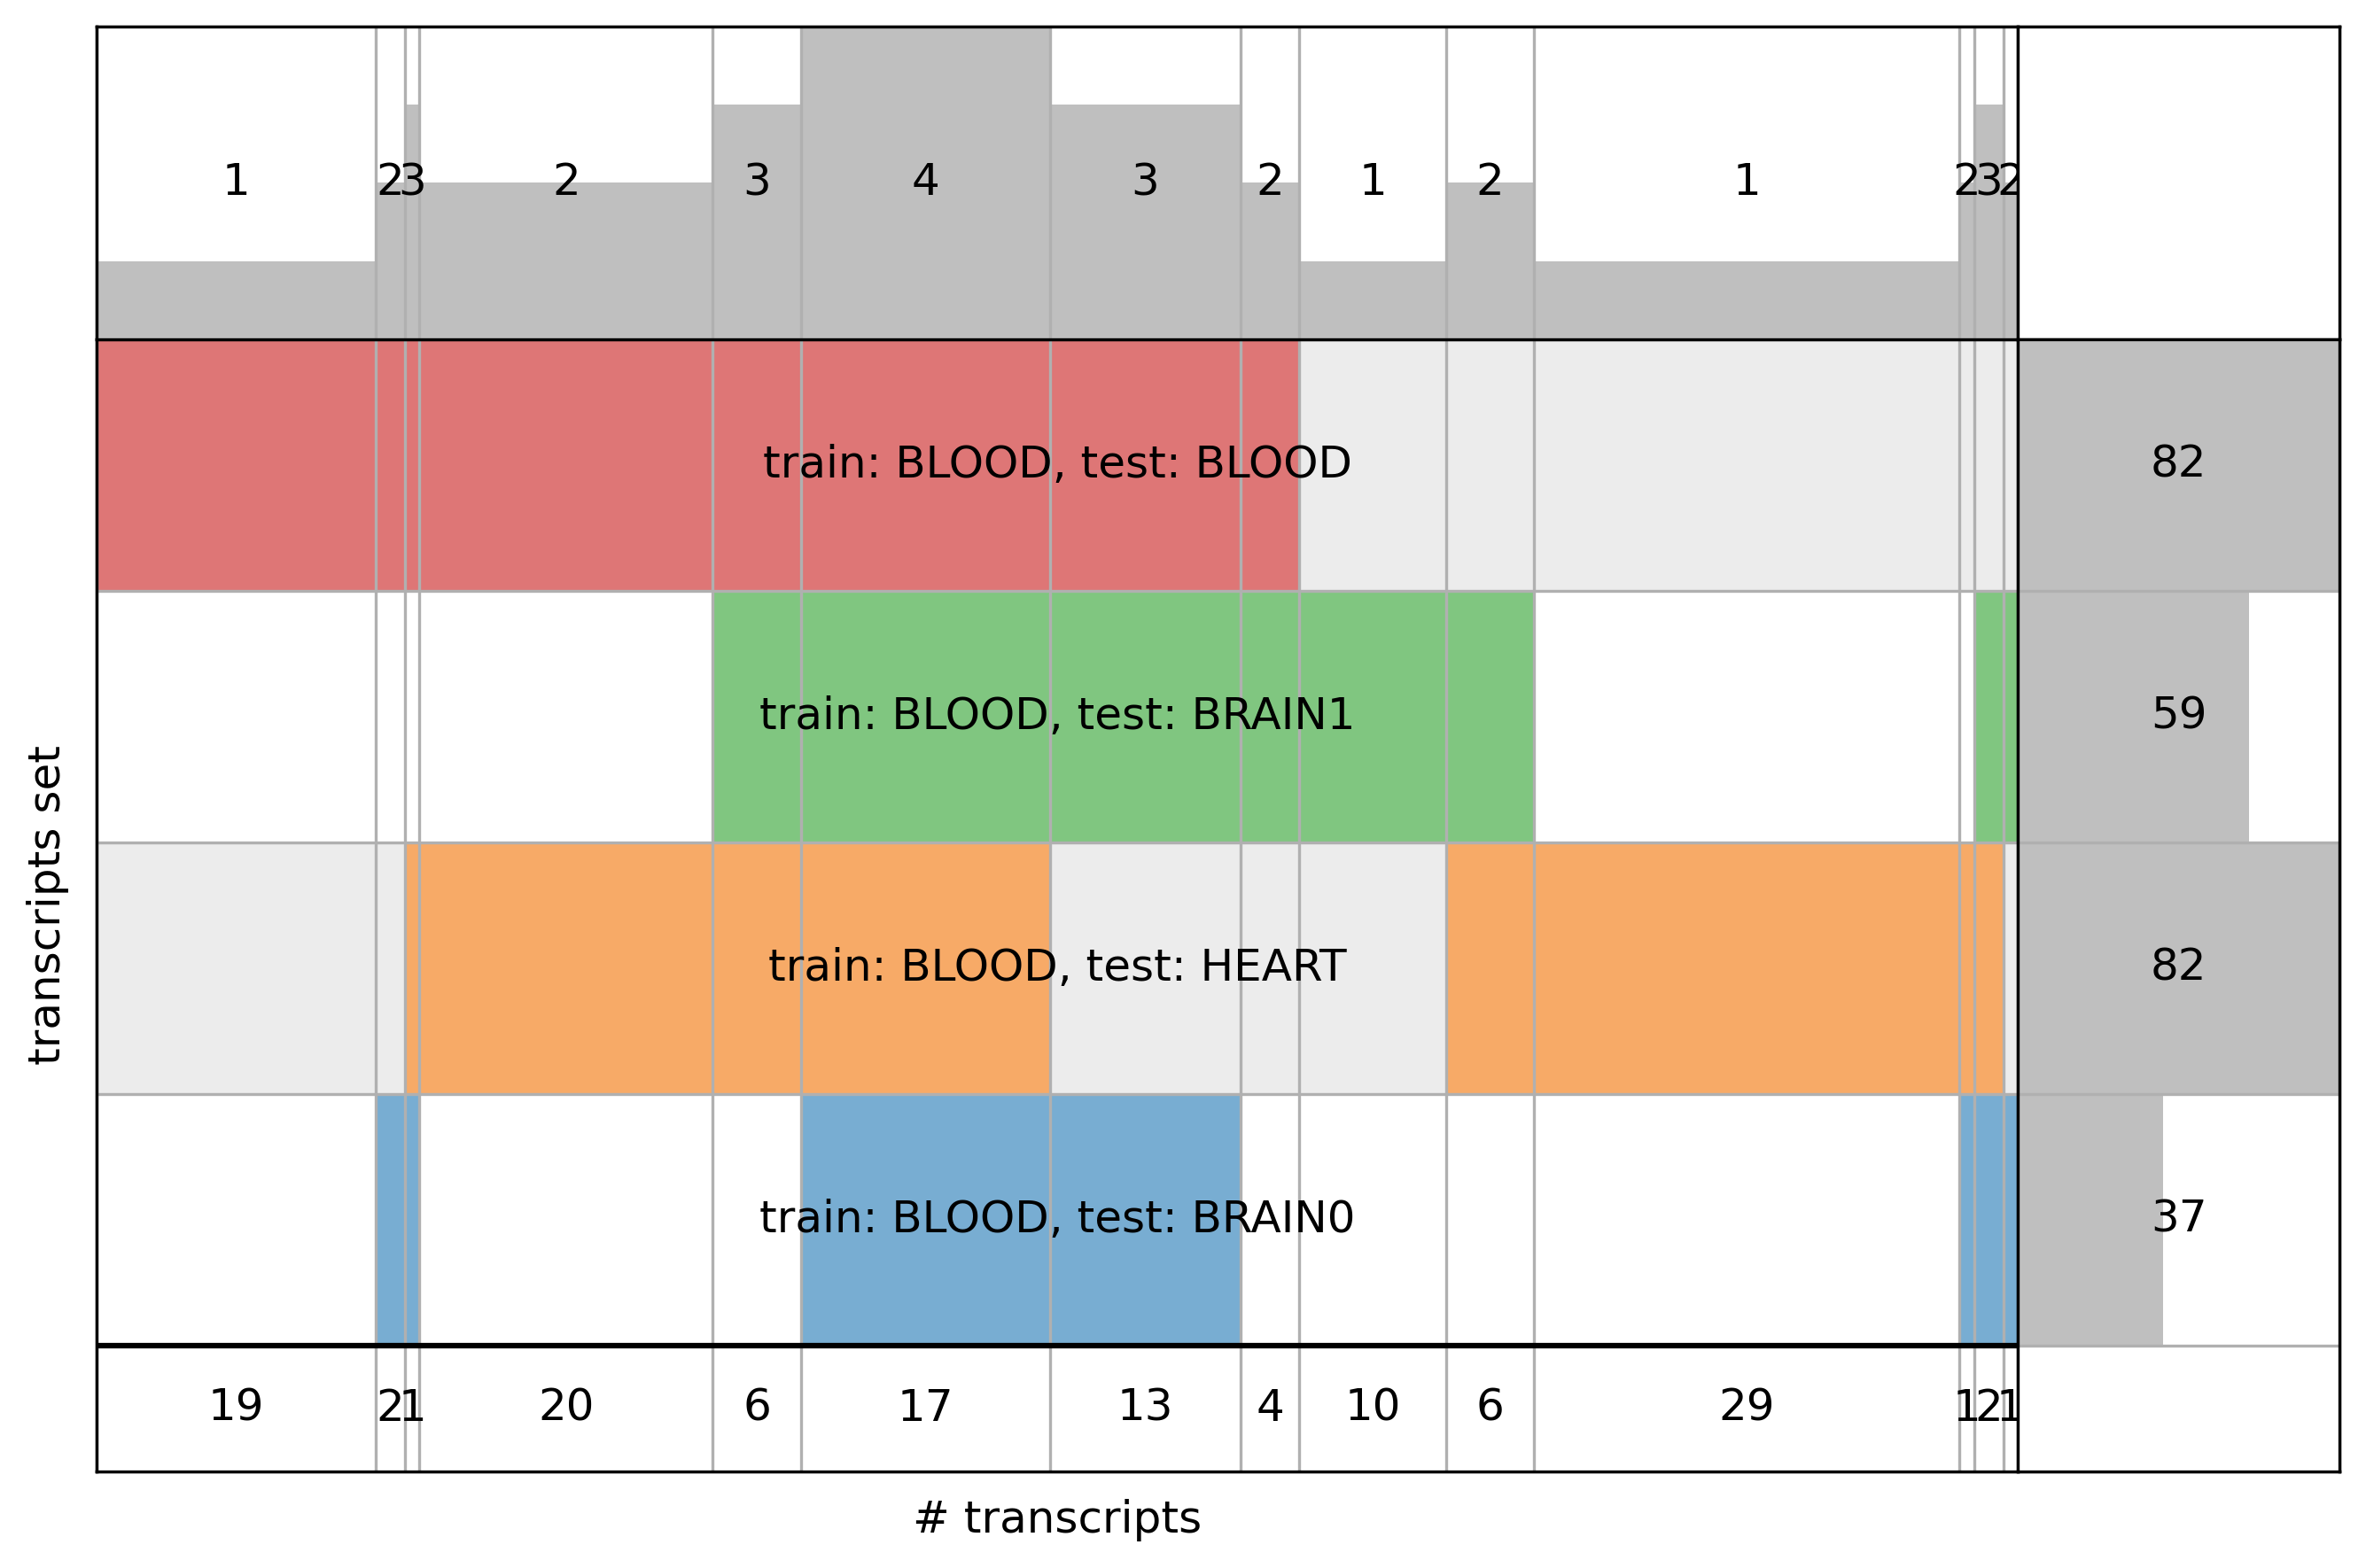

In [11]:
# chrXY_df = {
#     # "names": transcripts_list,
#     'BRAIN0': [],
#     'HEART': [], 
#     'BRAIN1': [],
#     'None': []
#     }
# fig, axs= plt.subplots()
# for transcript in transcripts_list:
#     for organ in ['BRAIN0', "HEART", "BRAIN1", 'None']:
        
#         if transcript in transcripts_dict[organ]['chrXY']:
#             chrXY_df[organ].append(True)
#         else:
#             chrXY_df[organ].append(False)
# chrXY_df = pd.DataFrame.from_dict(chrXY_df)
# 
# UpSet(chrXY_df, subset_size='count').plot()

# for sex in ['chrXY', 'chrX', 'chrY', 'autosome']:

row_names = {
    "BRAIN0": "train: BLOOD, test: BRAIN0", 
    "HEART": "train: BLOOD, test: HEART", 
    "BRAIN1": "train: BLOOD, test: BRAIN1", 
    "BLOOD": "train: BLOOD, test: BLOOD",
}

sex = ['chr_aXY', 'chr_aX', 'chr_aY', 'autosomes'][3]
test_dict = {}
for organ in ['BRAIN0', "HEART", "BRAIN1", 'BLOOD']:
    test_dict[row_names[organ]] = set(transcripts_dict[organ][sex].tolist())

# UpSet(from_contents(test_dict), show_counts=True).plot()

plt.figure(figsize=(9, 6), dpi=300)
g = supervenn(list(test_dict.values()), list(test_dict.keys()),
        # sets_ordering="minimize gaps",
        chunks_ordering='minimize gaps',
        # side_plots=False
        )
plt.title(sex)
plt.tight_layout()
g.axes['main'].set_xlabel('# transcripts')
g.axes['main'].set_ylabel('transcripts set')


print("Chromosomes: ", sex)

membership = []
memb_data = []

for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)], ": ")
    print(g.chunks[el])
    # print(adata.var['gene_name'][list(g.chunks[el])])

    membership.append((np.array(list(test_dict.keys()))[list(el)]).tolist())
    memb_data.append(len(g.chunks[el]))

/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the origin

Text(0.5, 1.0, 'autosomes')

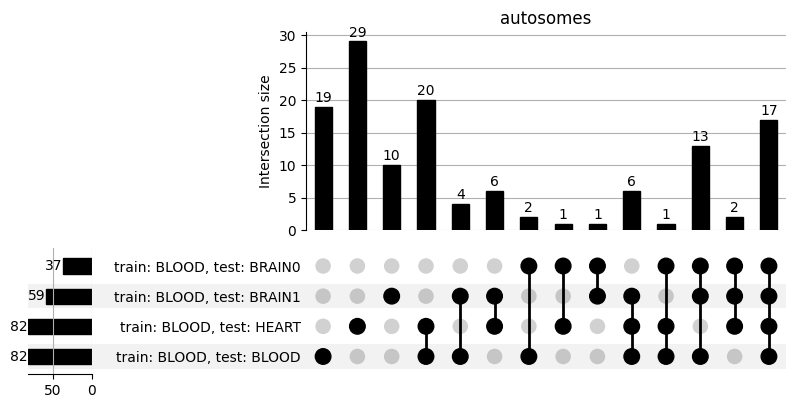

In [37]:
from upsetplot import from_memberships, plot

chr_names = {
    'chrXY': "chr_aXY" , 
    'chrX': "chr_aX" , 
    'chrY': "chr_aY" , 
    'autosome': "autosomes" 
}

example = from_memberships(membership, data=memb_data)
plot(example, show_counts=True)
plt.title(chr_names[sex])

Organ:  BRAIN1
['autosome'] : 
{'MSTRG.23169.2', 'MSTRG.21438.5', 'MSTRG.14482.3', 'ENST00000624344.1', 'ENST00000337338.9', 'ENST00000372583.6', 'MSTRG.28032.1', 'ENST00000548200.5', 'MSTRG.29554.27', 'ENST00000464587.2', 'ENST00000246080.4', 'MSTRG.20210.2', 'MSTRG.23851.1', 'MSTRG.3806.9', 'ENST00000494573.6', 'MSTRG.11500.1', 'ENST00000581584.5', 'MSTRG.14706.28', 'ENST00000280187.11', 'MSTRG.20911.32', 'MSTRG.1857.1', 'ENST00000412260.5', 'MSTRG.13450.7', 'MSTRG.1168.1', 'MSTRG.1141.6', 'MSTRG.34381.1', 'ENST00000476438.1', 'ENST00000300184.8', 'ENST00000565196.5', 'MSTRG.21565.11', 'MSTRG.3823.12', 'ENST00000303115.8', 'ENST00000548305.5', 'MSTRG.32512.1', 'MSTRG.17797.1', 'MSTRG.16726.28', 'MSTRG.21565.12', 'MSTRG.33150.3', 'ENST00000684774.1', 'MSTRG.5179.5', 'ENST00000372476.8', 'MSTRG.12050.13', 'ENST00000507765.1', 'MSTRG.20714.15', 'ENST00000375200.6', 'ENST00000589005.5', 'MSTRG.3529.27', 'MSTRG.27773.6', 'ENST00000413366.8', 'ENST00000651342.1', 'MSTRG.6368.4', 'ENST00000

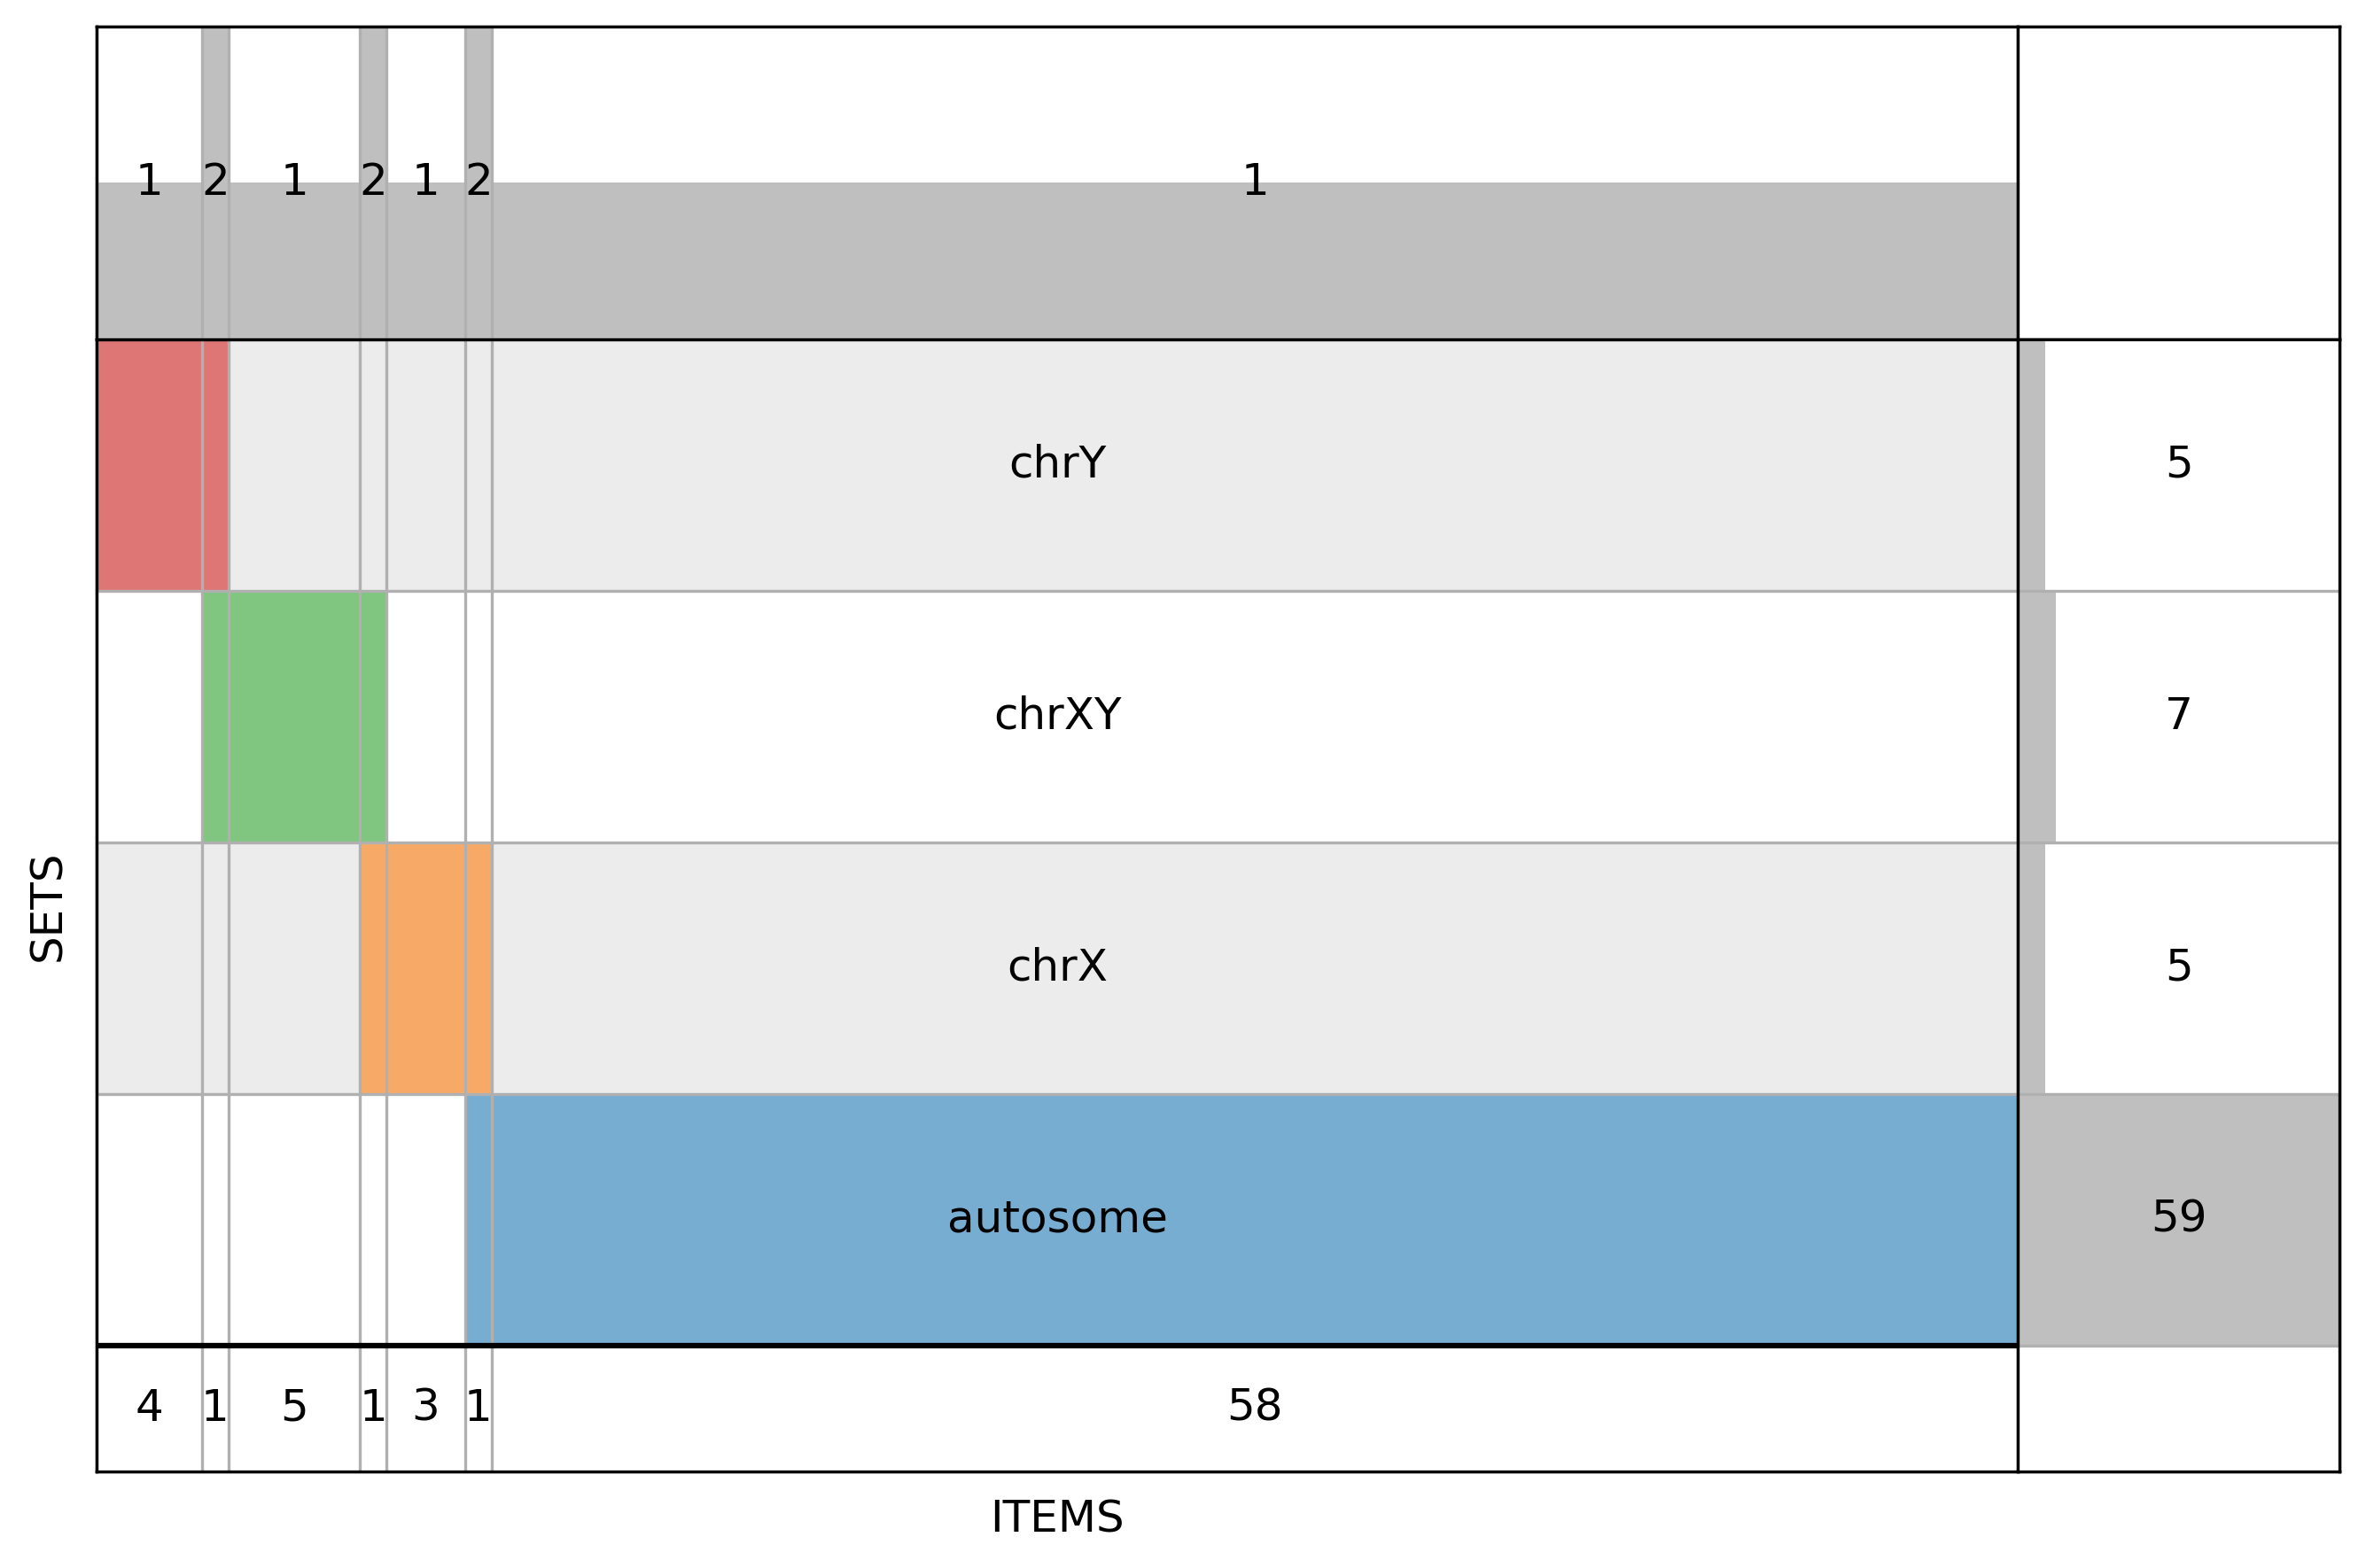

In [38]:
organ = ['BRAIN0', "HEART", "BRAIN1", 'None'][2]
test_dict = {}
for sex in ['chrXY', 'chrX', 'chrY', 'autosome']:
    test_dict[sex] = set(transcripts_dict[organ][sex].tolist())

# UpSet(from_contents(test_dict), show_counts=True).plot()

plt.figure(figsize=(9, 6), dpi=300)
g = supervenn(list(test_dict.values()), list(test_dict.keys()),
        sets_ordering="minimize gaps",
        chunks_ordering='minimize gaps')
plt.title(sex)
plt.tight_layout()

print("Organ: ", organ)
for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)], ": ")
    print(g.chunks[el])

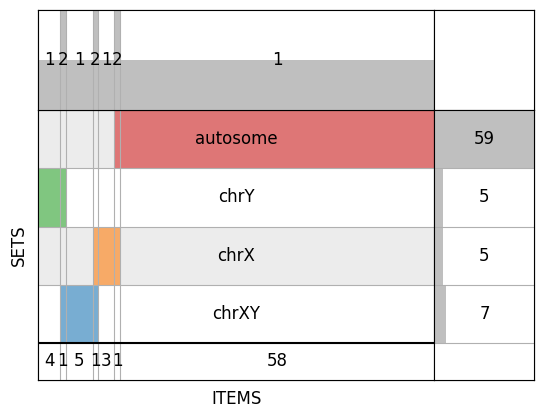

In [39]:
g = supervenn(list(test_dict.values()), list(test_dict.keys()), 
              sets_ordering=None)

In [40]:
for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)])

['autosome']
['chrX']
['chrXY']
['chrY']
['chrX' 'autosome']
['chrXY' 'chrX']
['chrXY' 'chrY']


In [41]:
np.array(list(test_dict.keys()))

array(['chrXY', 'chrX', 'chrY', 'autosome'], dtype='<U8')